# <span style="color: #4daafc">Legal Case Similarity Detection - Human Evaluation and Reference Results</span>
- [Environment](#environment)
- [Load Data](#load-data)
- [Law sections](#law-sections)
- [Legal cases analysis](#legal-cases-analysis)
    - [Count appel types](#count-appel-types)
    - [Count legal case by domain](#count-legal-case-by-domain)
    - [Case type vs domain (heatmap)](#case-type-vs-domain)
    - [Case references distribution](#case-references-distribution)
    - [Most common charges](#most-common-charges)
    - [Citation based relationship](#citation-based-relationship)
- [Reference results](#reference-results)

# Environment

### Import python packages

In [ ]:
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
from utils.file_utils import load_file, save_file
from utils.df import df_shape

# Load Data

**Note**: The below data is a result of human manual evaluation by non-legal experts. To simplify the work some text summaries were made by GPT 4o.

In [2]:
# load human evalauted data
f_path = 'data/lcsd_human_summary.xlsx'
df = load_file(file_name=f_path)

Successfully loaded DataFrame from data/lcsd_human_summary.xlsx


In [3]:
df_shape(df)
display(df.head(10))

Data shape: 100 rows x 12 columns


,case_id,case_number,type,domain,charges,applicants,respondent,request,sentencing_prev,sentencing_curr,decision,references
0,0,1108/97,civil appeal,procedural decision - extension request,[],[Marhiv Aviv],[State of Israel],['extension of time to file an appeal'],NaN,['The request for an extension of time was gra...,appeal accepted,"[], [1108/97]"
1,1,4477/00,civil appeal,family law - divorce,[''],"['Ludmila Vorobyov', 'Grigory Vorobyov']",['Attorney General of Israel'],['divorce'],[''],['Jurisdiction over the dissolution of the Vor...,procedural decision,"[1(a)], [4477/00]"
2,2,1890/16,criminal appeal,sexual offenses,[Indecent act on a minor under 16],Yoram Ohayon,State of Israel,"['Ohayon appealed, arguing that the sentence w...",[],"['5 years in prison, 2 years of probation, com...",appeal dismissed,"[348(b), 345(a)(1), 345(b)(1), 355(a)], [82/96..."
3,3,7176/04,criminal appeal,drug offenses,[Possession of a dangerous drug not for person...,Yaron Talmi,State of Israel,['arguing that the current offense did not mee...,[],"[32 months in prison, including the activation...",appeal dismissed,"[7(a), 7(c), 13, 25, 811, 808(3), 151 ,145 (3)..."
4,4,3766/12,civil appeal,family law,[],4 individuals (no names),1 individual (no name),['dismiss the appeal because of late submissio...,[],['appeal dismiss on timing grounds was denied;...,appeal dismissed,"[471(c)(a), 471(c)(d)], [8467/06, 1788/06, 501..."
5,5,8178/12,civil appeal,fees and compensation,[],"['attorney Tzvi Salant', 'attorney Uri Penso']",['Yonatan Gottlieb'],['appelants requested approval of proposed psi...,NaN,The court rejected the proposed draft order su...,appeal dismissed,"[], [8178/12]"
6,6,3015/09,criminal appeal,"terrorism, national security, murder attempt, ...","['Attempted murder', 'Conspiracy to commit a c...",['State of Israel'],['Fuad Kadih'],['the sentence was too lenient given the gravi...,"['6 years of actual imprisonment', '12 months ...","['Court rejected the state’s appeal', 'The res...",appeal dismissed,"[3, 499(a)(1), 301(1), 144(b)], [1118/06, 1242..."
7,7,4272/05,criminal appeal,drug offense,Possession of a dangerous drug (heroin) not fo...,Amir Hajuj,State of Israel,sentence was too harsh,[30 months in prison and 8 months of probation],['the same as previous - no change']\ndecision...,appeal dismissed,[3121/04]
8,8,10467/08,civil appeal,real estate,[],['Omar Hajazi'],"[Adib Ayas, Riyad Diab, Majdoub Mamdouh, Tisir...",['Appelant appealled against the Haifa Distric...,[],[appeal accepted; annulled the courte costs of...,appeal accepted,"[410(5), 423, 424, 199(4), 697(3), 385(2), 101..."
9,9,3330/11,civil appeal,insurance - road accident compensation,"['road accident, recognized as work accident, ...",['Egged Cooperative Society for Transport in I...,[Zion Levi],"['Egged and Ayalon Insurance appealed, arguing...","['Got compensation of ₪829,340 plus attorney f...",['Both the appeal and cross-appeal were reject...,appeal dismissed,"[4(c), 79(a), 6(b), 81], [329/08]"


# Law sections

Documented some common law sections I've met during the legal cases reading

In [4]:
# law sections and their description
law_data = [
    ("Section 329(a)(1)", "Aggravated assault"),
    ("Section 329(a)(2)", "Aggravated assault"),
    ("Section 332(2)", "Endangering life in a public way (driving offense)"),
    ("Section 275", "Obstruction of a police officer"),
    ("Section 1(a)", "Authorizing the Supreme Court President to assign jurisdiction in matters of civil divorce where no religious court has authority"),
    ("Section 499(a)(1)", "Conspiracy to commit a crime"),
    ("Section 12(1)", "Entry into Israel"),
    ("Section 144(b)", "Illegal possession of a firearm"),
    ("Section 340(a)(a)", "Firing a firearm in a residential area"),
    ("Section 47(a)", "Forcible resistance to arrest"),
    ("Section 10(a)", "Driving without a license"),
    ("Section 67", "Driving while disqualified"),
    ("Section 2(a)", "Driving without insurance"),
    ("Section 273", "Assault on a police officer"),
    ("Section 380", "An attack that causes actual damage"),
    ("Section 21(c)", "Transport related"),
    ("Section 21(b)(2)", "Transport related"),
    ("Section 68", "Transport related"),
    ("Section 345(b)(4)", "Rape"),
    ("Section 345(b)(3)", "Rape"),
    ("Section 345(a)(1)", "Rape"),
    ("Section 347(b)", "Sodomy"),
    ("Section 374(a)", "Kidnapping for sexual offenses"),
    ("Section 377(a)(a)(7)", "Kidnapping for sexual offenses"),
    ("Section 402(b)", "Robbery"),
    ("Section 402(a)", "Robbery"),
    ("Section 334", "Assault causing injury"),
    ("Section 1(a)(a)(1)", "Extradition Law"),
    ("Section 263(1)(3)", "Commercial fraud"),
    ("Section 7", "The VAT Law (transaction price = agreed price)"),
    ("Section 10", "Adjustments for special relationships"),
    ("Section 77", "Best judgment assessment where reports are inaccurate"),
]

# create DataFrame
df_laws = pd.DataFrame(law_data, columns=["Law Section", "Description"])

df_laws

,Law Section,Description
0,Section 329(a)(1),Aggravated assault
1,Section 329(a)(2),Aggravated assault
2,Section 332(2),Endangering life in a public way (driving offe...
3,Section 275,Obstruction of a police officer
4,Section 1(a),Authorizing the Supreme Court President to ass...
5,Section 499(a)(1),Conspiracy to commit a crime
6,Section 12(1),Entry into Israel
7,Section 144(b),Illegal possession of a firearm
8,Section 340(a)(a),Firing a firearm in a residential area
9,Section 47(a),Forcible resistance to arrest


# Legal cases analysis

### Count appel types

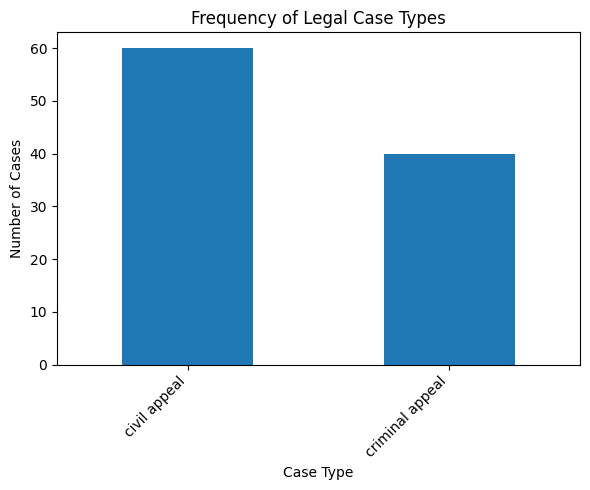

In [5]:
# count civial/criminal cases
type_counts = df['type'].value_counts().sort_values(ascending=False)

# plot
plt.figure(figsize=(6, 5))
type_counts.plot(kind='bar')
plt.title("Frequency of Legal Case Types")
plt.xlabel("Case Type")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Count legal case by domain

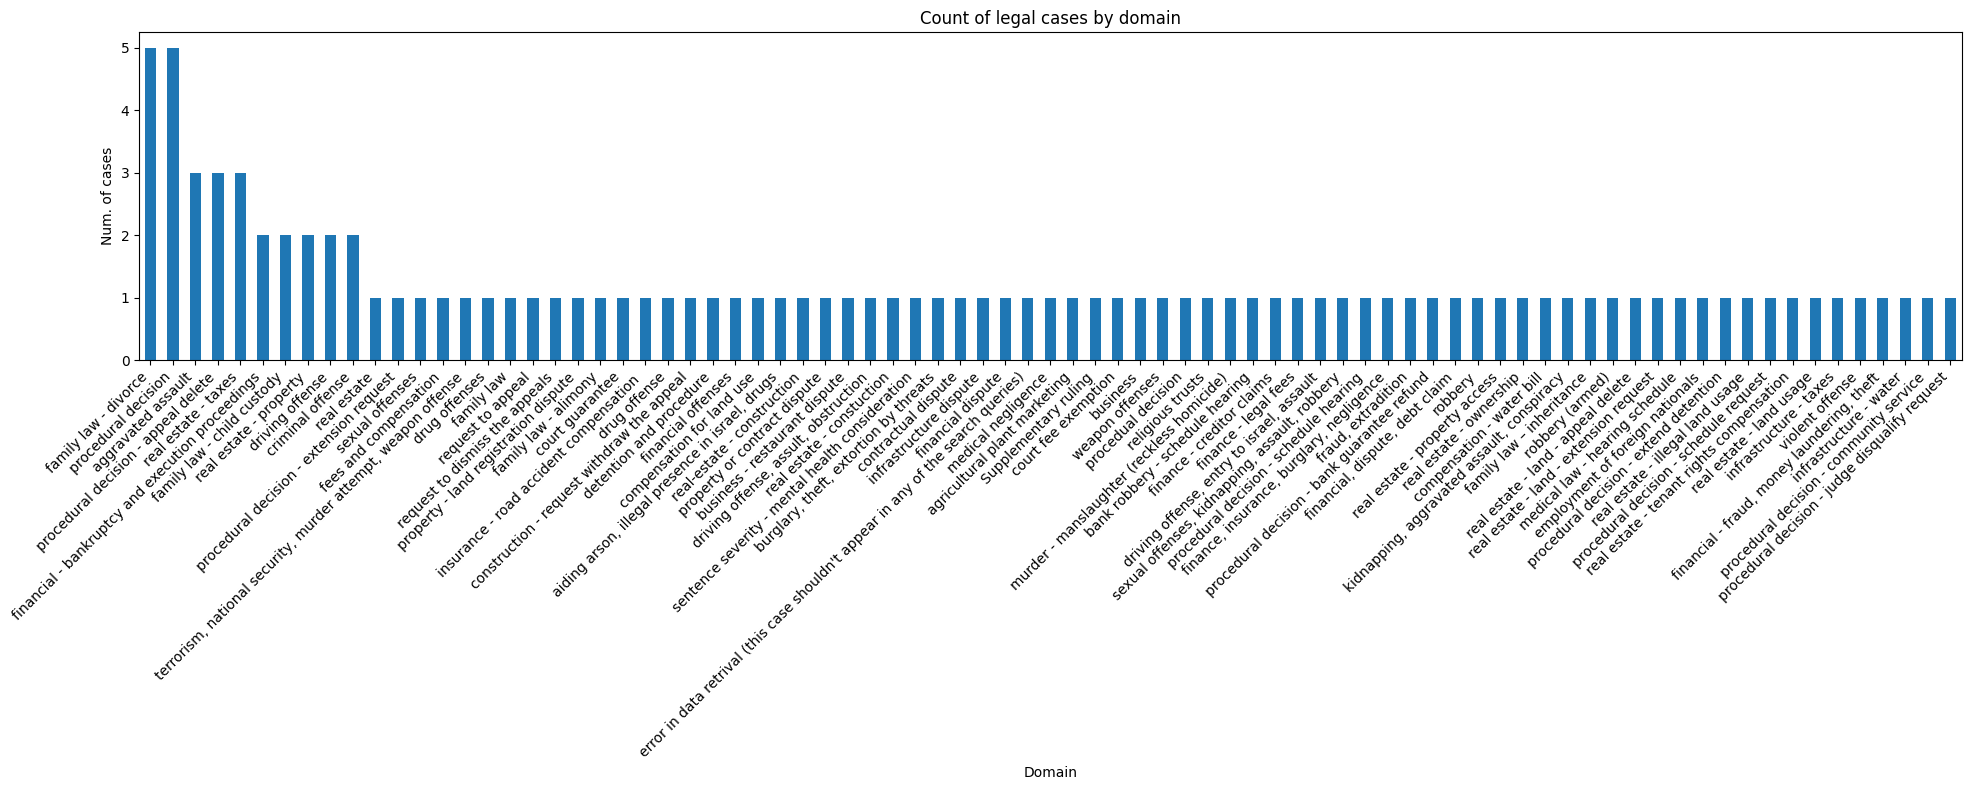

In [6]:
# Count the cases for each domain 
domain_counts = df['domain'].value_counts().sort_values(ascending=False)

# plot
plt.figure(figsize=(20, 8))
domain_counts.plot(kind='bar')
plt.title("Count of legal cases by domain")
plt.xlabel("Domain")
plt.ylabel("Num. of cases")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Case type vs domain

The heatmap shows the distribution of legal case domains across different case types: civil vs criminal appeals

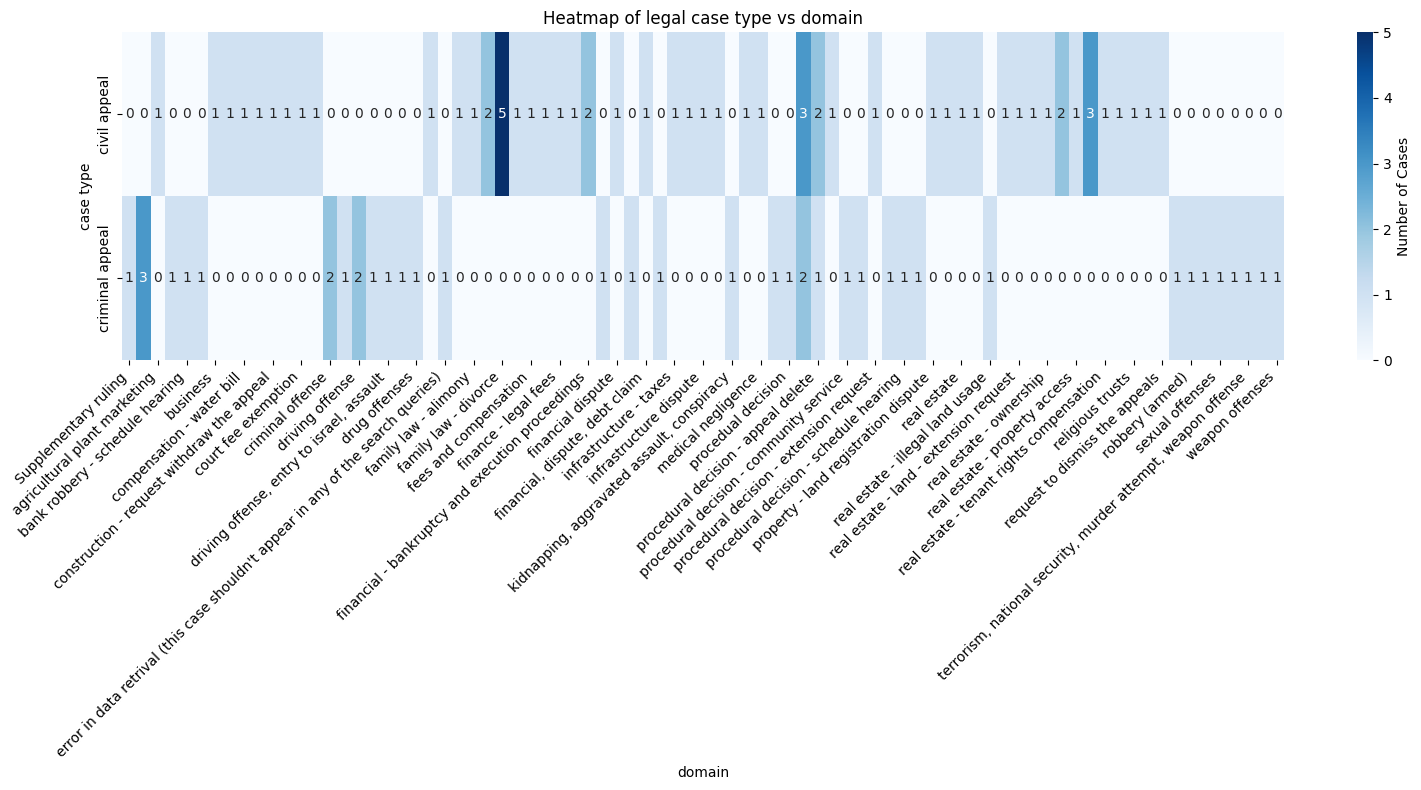

In [7]:
# create pivot tabke
pivot_table = df.pivot_table(index='type', columns='domain', aggfunc='size', fill_value=0)

# plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Cases'})
plt.title('Heatmap of legal case type vs domain')
plt.ylabel('case type')
plt.xlabel('domain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation**:
* Most common domains is criminal appeals:sexual offenses, drug offenses, assault.
* Most common domains in civial appeals: family law - divorce,  procedural decisions

### Case references distribution

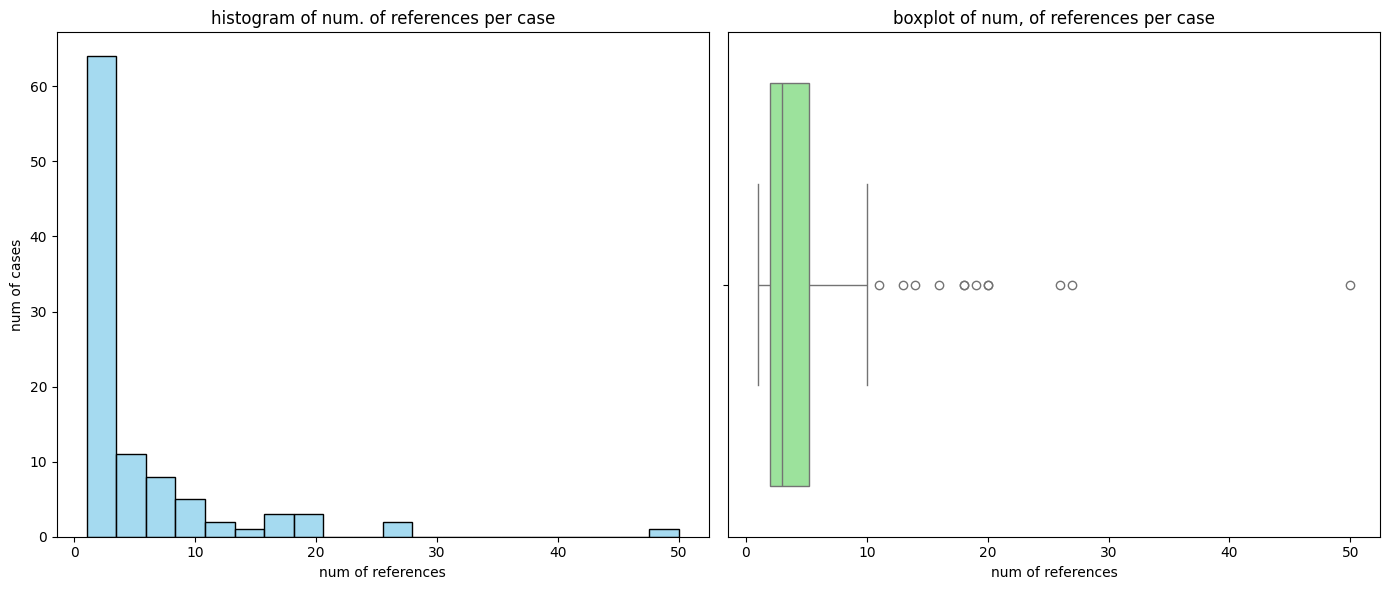

In [8]:
# Convert references column to count of references per case
df['num_references'] = df['references'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Plot histogram and boxplot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
sns.histplot(df['num_references'], bins=20, kde=False, ax=axes[0], color='skyblue')
axes[0].set_title('histogram of num. of references per case')
axes[0].set_xlabel('num of references')
axes[0].set_ylabel('num of cases')

# Boxplot
sns.boxplot(x=df['num_references'], ax=axes[1], color='lightgreen')
axes[1].set_title('boxplot of num, of references per case')
axes[1].set_xlabel('num of references')

plt.tight_layout()
plt.show()

**Observation**:
* Most cases have less than 10 references (law sections + other cases citations)
* Several outlier with big amount of references - legally complex cases with many precedents (apeals and review from previous decicisions)


### Most common charges

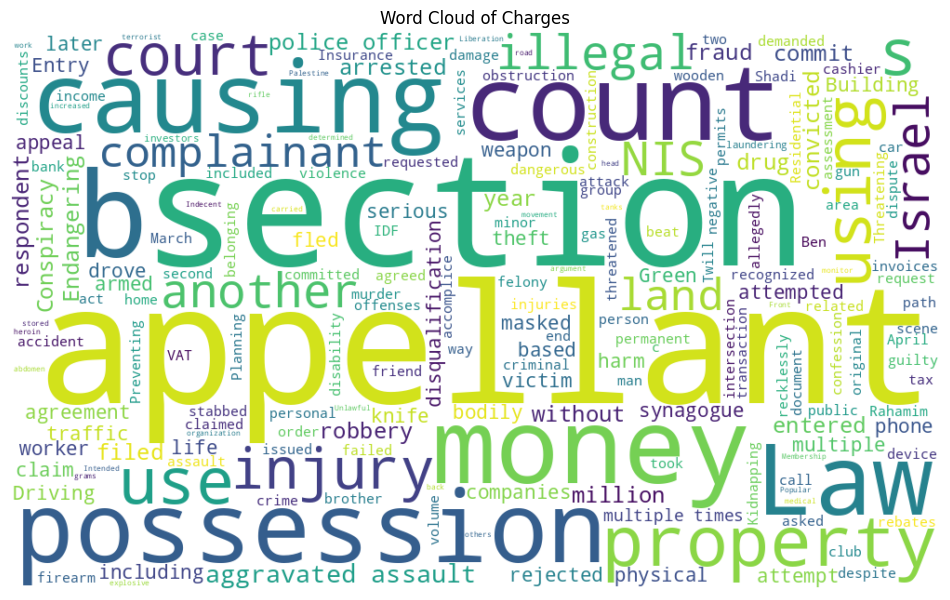

In [9]:

# Combine all charges into a single string
all_charges = df['charges'].dropna().astype(str).str.strip("[]'").str.replace("', '", ' ').str.replace(",", '').str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(all_charges)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Charges")
plt.show()

**Observation**:
* Most frequent: "property", "assault", "drug", "fraud", "armed", "robbery", "conspiracy", etc.
* Less frequent, but have a nature of serious offenses - "terrorist", "explosive" "rape", "minor" and "dangerous"  

### Citation based relationship

Display legal case and it's relation to other cases based on citations (law sections and legal case mention)

In [10]:
def extract_references(ref_str):
    if pd.isna(ref_str):
        return []
    pattern = r'\d{1,5}/\d{2}|\d{1,4}(?:\([a-zA-Zא-ת\d]{1,3}\))+|\b\d{1,4}\b'
    return re.findall(pattern, ref_str)

# apply extract references function to DataFrame
df["extracted_references"] = df["references"].apply(lambda x: extract_references(str(x)))

# create default dict
reference_to_cases = defaultdict(set)

for idx, refs in df["extracted_references"].items():
    for ref in refs:
        reference_to_cases[ref].add(idx)

# create similarity map
similar_cases_map = {}

for idx, refs in df["extracted_references"].items():
    similar = set()
    for ref in refs:
        similar.update(reference_to_cases[ref])
    similar.discard(idx)
    if similar:
        similar_cases_map[df.loc[idx, "case_number"]] = [df.loc[i, "case_number"] for i in similar]

# conver to DataFrame
similar_cases_df = pd.DataFrame.from_dict(
    similar_cases_map, orient='index'
).reset_index().rename(columns={"index": "case_number"})

similar_cases_df

,case_number,0,1,2,3,4,5,6
0,4477/00,140/01,6386/00,9376/00,1385/01,None,None,None
1,1890/16,319/21,None,None,None,None,None,None
2,7176/04,3015/09,9812/16,9312/03,None,None,None,None
3,3015/09,7176/04,7516/12,6068/21,4182/10,8750/16,9312/03,1494/07
4,10467/08,9312/03,None,None,None,None,None,None
5,3330/11,3804/19,None,None,None,None,None,None
6,3226/10,8750/16,None,None,None,None,None,None
7,4882/06,1494/07,None,None,None,None,None,None
8,2061/01,4918/01,None,None,None,None,None,None
9,9763/05,6546/22,None,None,None,None,None,None


Plot network graph based on citations (legal laws + legal case precidents)

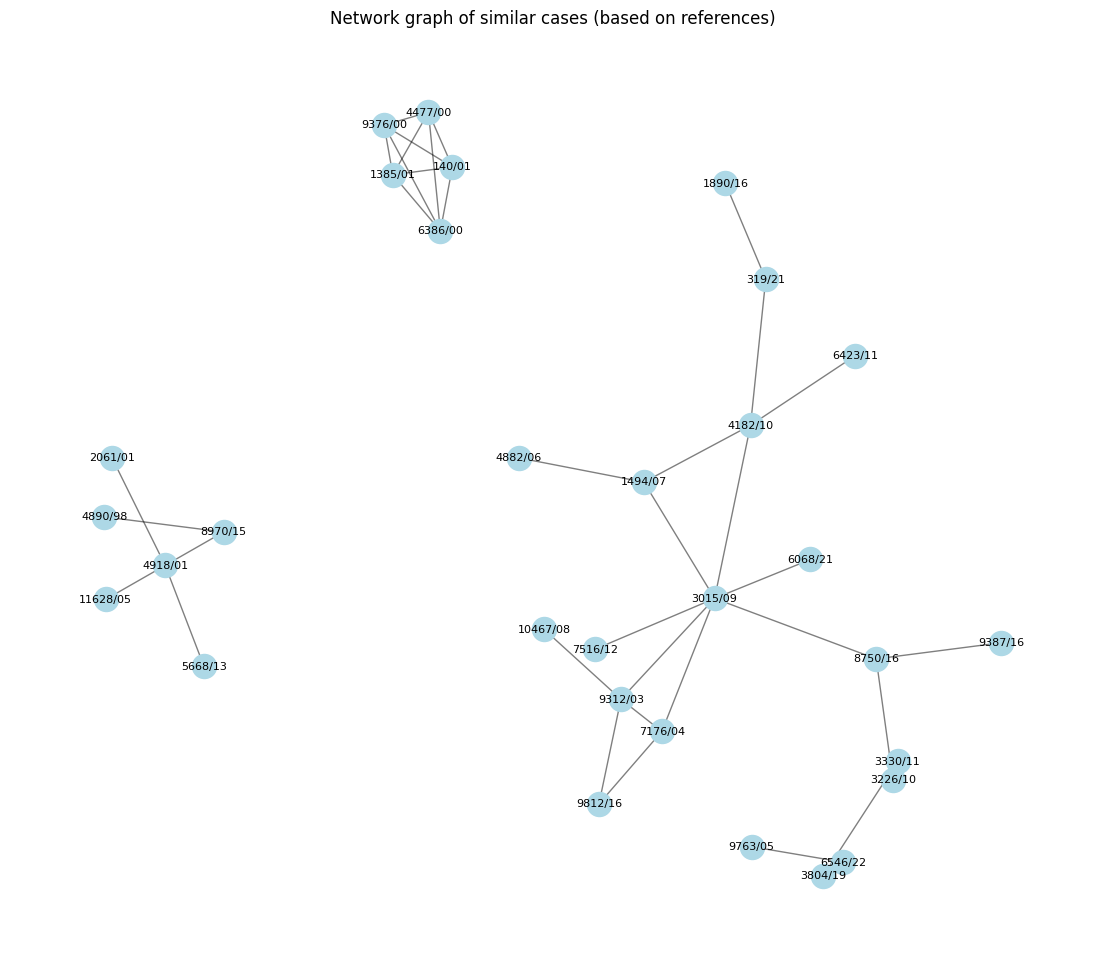

In [11]:
# convert dictionary to long format for network edges
edges = []
for source, targets in similar_cases_map.items():
    for target in targets:
        edges.append((source, target))

# create graph from edges
G = nx.Graph()
G.add_edges_from(edges)

# draw the graph
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.4, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Network graph of similar cases (based on references)")
plt.axis('off')
plt.show()

# Reference results

The below data consists of 5 chosen cases followed by human and ChatGPT 4o results of 3 similar cases selection.
- Human evaluation - based on summarized 100 cases with domain/topic, charges that were applied, sentencing and manually retrieved ciatations from the documents 
- ChatGTP 4o evaluation - GAI was prompted to find 3 similar cases based on manual reading

In [12]:
data = [
    {'case_number': '1494/07', 'case_type': 'criminal appeal', 'domain': 'driving offense', 'tool': 'human', 'result': ['4882/06', '7092/03', '8970/15']},
    {'case_number': '1494/07', 'case_type': 'criminal appeal', 'domain': 'driving offense', 'tool': 'ChatGPT 4o', 
     'result':['4882/06', '8970/15', '319/21'], 
     'prompt': "Please use the attached dataset of court cases. Please, find most 3 most similar cases to 1494/07. Please read the documents and don't use measurements like cosine similarity. Provide the output in bullet points",
     'output': 
"""Based on close reading and thematic comparison of the document for case **1494/07** (which involves reckless driving, fleeing from police, endangerment of the public, and sentencing for “סיכון חיי אדם בנתיב תחבורה”), here are the **3 most similar cases**:
---
Case 4882/06
Similarity Reason: Extremely close match in factual context. The accused in this case also drove recklessly through urban streets, fled from police, endangered pedestrians and vehicles, and was charged with *סיכון חיי אדם בנתיב תחבורה* and other related offenses.
Key Match Points:
* High-speed chase in Be'er Sheva.
* Ignoring police instructions and creating traffic hazards.
* Sentencing included 3 years in prison and long driving disqualification.
---
Case 8970/15
Similarity Reason: Involves reckless driving while evading police, illegal transport of persons, and causing danger to life. Multiple traffic and criminal violations.
Key Match Points:
* Defendant drove while disqualified and without insurance.
* Engaged in dangerous driving while fleeing a police unit.
* Sentenced to significant jail time (75 months) and heavy financial penalties.
---
Case 319/21
Similarity Reason: Although the primary charge is sexual violence, this case includes elements of abduction using a car, high-speed driving against the will of the victim, and physical resistance to law enforcement.
Key Match Points:
* Victim trapped in vehicle.
* Accused ignored pleas to stop the car and drove aggressively.
* Involves use of a vehicle as a means to commit a crime.
---
Would you like summaries of each of these cases in a structured format or comparisons to help with legal case similarity modeling?
"""},
    {'case_number': '9376/00', 'case_type': 'civil appeal', 'domain': 'family law - divorce', 'tool': 'human', 'result': ['1385/01', '4477/00', '6386/00']},
    {'case_number': '9376/00', 'case_type': 'civil appeal', 'domain': 'family law - divorce', 'tool': 'ChatGPT 4o', 
     'result':['4477/00', '1385/01', '6386/00'], 
     'prompt': "Please use only the attached dataset of court cases. Please, find most 3 most similar cases to 9376/00. Please read the documents and don't use measurements like cosine similarity. Provide the output in bullet points",
     'output': 
"""The most similar court cases to **9376/00** (which deals with *jurisdiction for marriage dissolution under special cases*) are:
4477/00:
  * Also issued under "חוק שיפוט בענייני התרת נישואין (מקרים מיוחדים), התשכ"ט–1969"
  * Involves the President of the Supreme Court assigning jurisdiction for a marriage dissolution
  * Document structure and legal framework are nearly identical
  
1385/01:
  * Another jurisdiction decision under the same legal statute
  * Concerns the question of which regional court has authority over a dissolution of marriage case

6386/00:
  * Again under the same specific statute governing jurisdiction in unique marriage dissolution cases
  * The legal reasoning and format match that of 9376/00

These three cases closely mirror the legal nature and structure of 9376/00.
"""},
    {'case_number': '5668/13', 'case_type': 'criminal appeal', 'domain': 'financial - fraud, money laundering, theft', 'tool': 'human', 'result': ['7817/18', '6423/11', '2542/19']},
    {'case_number': '5668/13', 'case_type': 'criminal appeal', 'domain': 'financial - fraud, money laundering, theft', 'tool': 'ChatGPT 4o', 
     'result':['4446/20', '6423/11', '7176/04'], 
     'prompt': "Please use only the attached dataset of court cases. Please, find most 3 most similar cases to 5668/13. Please read the documents and don't use measurements like cosine similarity. Provide the output in bullet points",
     'output': 
"""Based on manual reading of the documents in the dataset, the three most similar cases to **5668/13** (which involved a large-scale Ponzi scheme, over 200 financial offenses including aggravated fraud, forgery, and money laundering) are:
4446/20
  * Involves a significant number of fraud and white-collar crime offenses.
  * Discusses sentencing and moral culpability of financial criminals.
  * Echoes the tone and complexity of 5668/13 regarding the severity of the economic damage.
  
6423/11
  * Addresses fraud involving abuse of trust and multiple criminal charges.
  * The structure of the verdict includes references to sentencing principles in economic crimes.
  * Appeals to Supreme Court for sentence reduction due to special personal circumstances—similar to 5668/13.
  
7176/04
  * Although not identical in scale, it includes aggravated deceit and financial offenses.
  * Discusses principles of punishment in white-collar crime and deterrence.
  * Focuses on repeat offenses and cumulative sentencing logic.

These cases are the closest in legal subject matter, complexity, and tone, aligning well with the financial and moral dimensions highlighted in 5668/13.
"""},
    {'case_number': '3015/09', 'case_type': 'criminal appeal', 'domain': 'terrorism, national security, murder attempt, weapon offense', 'tool': 'human', 'result': ['6068/21', '8750/16', '4182/10']},
    {'case_number': '3015/09', 'case_type': 'criminal appeal', 'domain': 'terrorism, national security, murder attempt, weapon offense', 'tool': 'ChatGPT 4o', 
     'result':['8750/16', '6068/21', '4882/06'], 
     'prompt': "Please, use only the attached dataset of court cases. Please, Find most 3 most similar cases to 3015/09. Read the documents and don't use measurements like cosine similarity. Provide the output in bullet points",
     'output': 
"""Based on manual analysis and comparison of content (without cosine similarity), here are the **3 most similar cases to 3015/09** from the dataset:
---
### Target Case 3015/09 – Summary:

Charges: Attempted murder, possession of explosives, illegal weapon possession, membership in a terrorist organization.
Details: The defendant stored and later planted explosive devices on behalf of the Popular Front for the Liberation of Palestine (PFLP), indicating politically motivated violence and terrorism.
---

### Most Similar Cases (Top 3)

8750/16
  * Similarity: Also involves collaboration in a politically motivated violent attack.
  * Details: The defendant acted as a lookout during a Molotov cocktail attack that caused serious injuries and set a car on fire. He was convicted of aiding in aggravated assault and conspiracy to commit a crime.
  * Common Elements: Terrorist context, organized planning, conspiracy, violent means.

6068/21
  * Similarity: Involves illegal possession and discharge of firearms near a public event.
  * Details: The defendant, armed with an illegal firearm, fired shots into the air near a wedding. He coordinated with others who were also armed.
  * Common Elements: Illegal weapons, public safety threat, group coordination.

4882/06
  * Similarity: Contains extreme recklessness and endangerment, though not terrorism-specific.
  * Details: High-speed car chase in a populated area, running red lights, and endangering lives including law enforcement.
  * Common Elements: Life-threatening behavior, severe public risk, confrontation with police.

---
Let me know if you’d like a tabular comparison or deeper summaries.
"""},
    {'case_number': '6746/98', 'case_type': 'criminal appeal', 'domain': 'bank robbery', 'tool': 'human', 'result': ['319/21', '7516/12', '4182/10']},
    {'case_number': '6746/98', 'case_type': 'criminal appeal', 'domain': 'bank robbery', 'tool': 'ChatGPT 4o', 
     'result': ['7516/12', '4182/10', '319/21'], 
     'prompt': "Please use the attached dataset of court cases. Please, find most 3 most similar cases to 6746/98. Please read the documents and don't use measurements like cosine similarity. Provide the output in bullet points",
     'output': 
"""After reviewing the full documents of candidate cases, here are the **3 most similar cases to 6746/98** (bank robbery with a fake weapon, coordinated with an accomplice):
---
7516/12 – *Robbery with a fake gun by masked minor at post office*
  * The defendant, just under 18, entered a post office with a fake gun, masked, and yelled “This is a robbery.” He took ₪3,900 and fled but was caught shortly after.
  * Similarities:
	* Use of a fake weapon
	* Robbery of a financial institution
	* Masked assailant
	* Threat to employees under duress
---

4182/10 – *Armed group robbery at a gas station*
  * Three men, masked, robbed a gas station convenience store with physical threats. They entered quickly, wielding weapons, and stole money.
  * Similarities:
    * Group action with a clear plan
    * Use of weapon and threat
    * Night-time ambush, element of surprise
    * Sentence involved multiple years in prison
---

319/21 – *Fatal stabbing following altercation***
  * The appellant was convicted of murder after stabbing a victim during a confrontation. The incident stemmed from a heated exchange, escalated quickly, and ended in a fatal wound inflicted with a knife. The appellant fled the scene but was later apprehended.
  * Similarities:
	* Use of a weapon (knife) in a sudden, high-stress situation
	* Victim trauma and fatal outcome
	* Legal focus on severity of offense and appropriateness of sentencing
	* Sentencing appeal centered on proportionality and the appellant's circumstances
---

Let me know if you want these summarized in a table or compared side by side by legal sections and sentence length.
"""},
]

In [13]:
df_ref_results = pd.DataFrame(data)
df_ref_results

,case_number,case_type,domain,tool,result,prompt,output
0,1494/07,criminal appeal,driving offense,human,"[4882/06, 7092/03, 8970/15]",NaN,NaN
1,1494/07,criminal appeal,driving offense,ChatGPT 4o,"[4882/06, 8970/15, 319/21]",Please use the attached dataset of court cases...,Based on close reading and thematic comparison...
2,9376/00,civil appeal,family law - divorce,human,"[1385/01, 4477/00, 6386/00]",NaN,NaN
3,9376/00,civil appeal,family law - divorce,ChatGPT 4o,"[4477/00, 1385/01, 6386/00]",Please use only the attached dataset of court ...,The most similar court cases to **9376/00** (w...
4,5668/13,criminal appeal,"financial - fraud, money laundering, theft",human,"[7817/18, 6423/11, 2542/19]",NaN,NaN
5,5668/13,criminal appeal,"financial - fraud, money laundering, theft",ChatGPT 4o,"[4446/20, 6423/11, 7176/04]",Please use only the attached dataset of court ...,Based on manual reading of the documents in th...
6,3015/09,criminal appeal,"terrorism, national security, murder attempt, ...",human,"[6068/21, 8750/16, 4182/10]",NaN,NaN
7,3015/09,criminal appeal,"terrorism, national security, murder attempt, ...",ChatGPT 4o,"[8750/16, 6068/21, 4882/06]","Please, use only the attached dataset of court...",Based on manual analysis and comparison of con...
8,6746/98,criminal appeal,bank robbery,human,"[319/21, 7516/12, 4182/10]",NaN,NaN
9,6746/98,criminal appeal,bank robbery,ChatGPT 4o,"[7516/12, 4182/10, 319/21]",Please use the attached dataset of court cases...,After reviewing the full documents of candidat...


### Save referene results

In [14]:
f_name_ref_results = 'data/lcsd_ref_results.xlsx'
save_file(df_ref_results, f_name_ref_results)

DataFrame successfully saved to data/lcsd_ref_results.xlsx
